In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_connectivity(params):
    """
    Generate the connectivity matrix for the mesh.

    Each element is defined by 4 nodes.
    Node ordering: [bottom-right, bottom-left, top-left, top-right].

    For example, for a 2x2 section of the mesh, the node IDs are arranged as follows:

         2 -------- 5 -------- 8     ^ y
         |          |          |
         |   el 1   |   el 3   |
         |          |          |
         1 -------- 4 -------- 7
         |          |          |
         |   el 0   |   el 2   |
         |          |          |
         0 -------- 3 -------- 6     ---> x

    Nodes are numbered from bottom-to-top, then left-to-right.
    The connectivity for an element is stored as:
      connectivity[el, 0] = bottom-right
      connectivity[el, 1] = bottom-left
      connectivity[el, 2] = top-left
      connectivity[el, 3] = top-right
    """
    num_elements_x = params["num_elements_x"]
    num_elements_y = params["num_elements_y"]
    num_nodes_y = params["num_nodes_y"]
    total_elements = params["total_elements"]

    connectivity = np.zeros((total_elements, 4), dtype=int)
    elem_index = 0
    for col in range(num_elements_x):
        for row in range(num_elements_y):
            connectivity[elem_index, 0] = (col + 1) * num_nodes_y + (row + 1) - 1
            connectivity[elem_index, 1] = (col) * num_nodes_y + (row + 1) - 1
            connectivity[elem_index, 2] = (col) * num_nodes_y + (row + 2) - 1
            connectivity[elem_index, 3] = (col + 1) * num_nodes_y + (row + 2) - 1
            elem_index += 1

    return connectivity


In [3]:
def assemble_global_stiffness_matrix(params, connectivity):
    """
    Assemble and return the global stiffness matrix KG by looping through all elements
    and summing their local stiffness matrices.
    
    For each element, 2x2 Gauss integration is performed using the gauss points
    and weights. The integration sums the contributions of the strain-displacement
    relations over each element.
    """
    total_dofs = params["total_dofs"]
    KG = np.zeros((total_dofs, total_dofs))
    num_elements_x = params["num_elements_x"]
    num_elements_y = params["num_elements_y"]
    gauss_points = params["gauss_points"]
    gauss_weights = params["gauss_weights"]
    half_width = params["half_width"]
    half_height = params["half_height"]
    det_jacobian = params["det_jacobian"]
    element_width = params["element_width"]
    element_height = params["element_height"]
    ground_modulus = params["ground_modulus"]
    modulus_gradient = params["modulus_gradient"]
    poisson_ratio = params["poisson_ratio"]
    thickness = params["thickness"]

    for col in range(num_elements_x):
        for row in range(num_elements_y):
            elem_number = col * num_elements_y + row
            KE = np.zeros((8, 8))
            # Loop over 2x2 Gauss integration points
            for i, xi in enumerate(gauss_points):
                for j, eta in enumerate(gauss_points):
                    B_local = compute_B(xi, eta, half_width, half_height)
                    # Map natural coordinate eta (range [-1,1]) to local coordinate in [0,1]
                    local_eta_mapped = (1 + eta) / 2.0
                    # Determine the depth (Y) from the surface to the Gauss point
                    Y_depth = (row + local_eta_mapped) * element_height
                    # Effective elastic modulus accounting for gradient
                    E_effective = ground_modulus + modulus_gradient * Y_depth
                    c1 = E_effective * (1 - poisson_ratio) / ((1 + poisson_ratio) * (1 - 2 * poisson_ratio))
                    C_local = np.array([
                        [c1, c1 * poisson_ratio / (1 - poisson_ratio), 0],
                        [c1 * poisson_ratio / (1 - poisson_ratio), c1, 0],
                        [0, 0, c1 * (1 - 2 * poisson_ratio) / (2 * (1 - poisson_ratio))]
                    ])

                    weight = gauss_weights[i] * gauss_weights[j]
                    KE += B_local.T @ C_local @ B_local * det_jacobian * weight * thickness

            # Assemble the local stiffness into the global matrix
            element_nodes = connectivity[elem_number, :]
            gdof = []
            for node in element_nodes:
                gdof.extend([2 * node, 2 * node + 1])
            gdof = np.array(gdof)
            for ii in range(8):
                for jj in range(8):
                    KG[gdof[ii], gdof[jj]] += KE[ii, jj]

    return KG



In [4]:
def compute_B(xi, eta, half_width, half_height):
    """
    Compute the strain-displacement (B) matrix for a 4-node quadrilateral element at a given natural coordinate (xi, eta).
    Returns a 3x8 numpy array corresponding to the contributions of the 4 nodes (u and v DOFs each).
    """
    # Derivatives of shape functions w.r.t natural coordinates (bilinear quadrilateral element)
    dN1_dxi  = 0.25 * (1 + eta)
    dN1_deta = 0.25 * (1 + xi)
    dN2_dxi  = -0.25 * (1 + eta)
    dN2_deta = 0.25 * (1 - xi)
    dN3_dxi  = -0.25 * (1 - eta)
    dN3_deta = -0.25 * (1 - xi)
    dN4_dxi  = 0.25 * (1 - eta)
    dN4_deta = -0.25 * (1 + xi)

    # Convert derivatives from natural to physical coordinates by dividing by half-dimensions
    dN1_dx = dN1_dxi / half_width
    dN1_dy = dN1_deta / half_height
    dN2_dx = dN2_dxi / half_width
    dN2_dy = dN2_deta / half_height
    dN3_dx = dN3_dxi / half_width
    dN3_dy = dN3_deta / half_height
    dN4_dx = dN4_dxi / half_width
    dN4_dy = dN4_deta / half_height

    # Assemble the B matrix
    B = np.zeros((3, 8))
    
    # Node 1
    B[0, 0] = dN1_dx
    B[1, 1] = dN1_dy
    B[2, 0] = dN1_dy
    B[2, 1] = dN1_dx
    
    # Node 2
    B[0, 2] = dN2_dx
    B[1, 3] = dN2_dy
    B[2, 2] = dN2_dy
    B[2, 3] = dN2_dx
    
    # Node 3
    B[0, 4] = dN3_dx
    B[1, 5] = dN3_dy
    B[2, 4] = dN3_dy
    B[2, 5] = dN3_dx
    
    # Node 4
    B[0, 6] = dN4_dx
    B[1, 7] = dN4_dy
    B[2, 6] = dN4_dy
    B[2, 7] = dN4_dx

    return B

In [5]:
def apply_boundary_conditions(KG, params):
    """
    Apply the boundary conditions to the global stiffness matrix KG.

    Boundary conditions:
      - Right edge: Fully constrained (both DOFs fixed)
      - Bottom edge: Fully constrained (both DOFs fixed)
      - Left edge: Only horizontal displacement (DOF 0) is restrained
    """
    num_nodes_y = params["num_nodes_y"]
    num_nodes_x = params["num_nodes_x"]
    
    # Right edge: nodes with column index = num_nodes_x - 1
    right_edge_nodes = [node for node in range(num_nodes_x * num_nodes_y) if (node // num_nodes_y) == (num_nodes_x - 1)]
    for node in right_edge_nodes:
        for dof in [2 * node, 2 * node + 1]:
            KG[dof, :] = 0
            KG[:, dof] = 0
            KG[dof, dof] = 1

    # Bottom edge: nodes with row index = num_nodes_y - 1
    bottom_edge_nodes = [node for node in range(num_nodes_x * num_nodes_y) if (node % num_nodes_y) == (num_nodes_y - 1)]
    for node in bottom_edge_nodes:
        for dof in [2 * node, 2 * node + 1]:
            KG[dof, :] = 0
            KG[:, dof] = 0
            KG[dof, dof] = 1

    # Left edge: nodes with column index = 0, only restrain horizontal displacement (DOF 0)
    left_edge_nodes = [node for node in range(num_nodes_x * num_nodes_y) if (node // num_nodes_y) == 0]
    for node in left_edge_nodes:
        dof = 2 * node  # horizontal DOF
        KG[dof, :] = 0
        KG[:, dof] = 0
        KG[dof, dof] = 1
    
    return KG

In [6]:

def create_load_vector(params):
    """
    Create and return the load vector R with applied footing pressure on selected nodes.
    """
    R = np.zeros(params["total_dofs"])
    num_nodes_y = params["num_nodes_y"]
    element_width = params["element_width"]
    footing_pressure = params["footing_pressure"]
    num_footing_elements = params["num_footing_elements"]

    for i in range(num_footing_elements):
        # Apply load on two adjacent nodes for each footing element
        node = num_nodes_y * i
        dof = 2 * node + 1      # vertical DOF
        R[dof] -= footing_pressure * element_width / 2.0
        node2 = node + num_nodes_y
        dof2 = 2 * node2 + 1
        R[dof2] -= footing_pressure * element_width / 2.0
    
    return R

In [7]:

def solve_displacements(KG, R):
    """
    Solve the linear system KG * U = R and return the displacement vector U.
    """
    U = np.linalg.solve(KG, R)
    return U

In [8]:

def compute_element_stresses(params, connectivity, U):
    """
    Compute the vertical stresses (sigma_yy) at the 4 Gauss points for each element
    and return an array of stresses per element.
    
    Gauss point ordering (from the nested loops):
      gp0: (xi, eta) = ( 1/sqrt3,  1/sqrt3)
      gp1: (xi, eta) = ( 1/sqrt3, -1/sqrt3)
      gp2: (xi, eta) = (-1/sqrt3,  1/sqrt3)
      gp3: (xi, eta) = (-1/sqrt3, -1/sqrt3)
    """
    num_elements_x = params["num_elements_x"]
    num_elements_y = params["num_elements_y"]
    total_elements = params["total_elements"]
    gauss_points = params["gauss_points"]
    half_width = params["half_width"]
    half_height = params["half_height"]
    element_height = params["element_height"]
    ground_modulus = params["ground_modulus"]
    modulus_gradient = params["modulus_gradient"]
    poisson_ratio = params["poisson_ratio"]

    stress_yy_elements = np.zeros((total_elements, 4))

    for col in range(num_elements_x):
        for row in range(num_elements_y):
            elem_number = col * num_elements_y + row
            element_nodes = connectivity[elem_number, :]
            gdof = []
            for node in element_nodes:
                gdof.extend([2 * node, 2 * node + 1])
            gdof = np.array(gdof)
            Ue = U[gdof]  # Element displacement vector (8,)

            local_stresses = np.zeros(4)
            gp_counter = 0
            for i, xi in enumerate(gauss_points):
                for j, eta in enumerate(gauss_points):
                    B_local = compute_B(xi, eta, half_width, half_height)
                    # Map natural coordinate to [0,1] for integration
                    local_eta_mapped = (1 + eta) / 2.0
                    Y_depth = (row + local_eta_mapped) * element_height
                    E_effective = ground_modulus + modulus_gradient * Y_depth
                    c1 = E_effective * (1 - poisson_ratio) / ((1 + poisson_ratio) * (1 - 2 * poisson_ratio))
                    C_local = np.array([
                        [c1, c1 * poisson_ratio / (1 - poisson_ratio), 0],
                        [c1 * poisson_ratio / (1 - poisson_ratio), c1, 0],
                        [0, 0, c1 * (1 - 2 * poisson_ratio) / (2 * (1 - poisson_ratio))]
                    ])
                    strain = B_local @ Ue
                    stress_local = C_local @ strain
                    # Store vertical stress (sigma_yy) which is the second component (index 1)
                    local_stresses[gp_counter] = stress_local[1]
                    gp_counter += 1
            stress_yy_elements[elem_number, :] = local_stresses

    return stress_yy_elements

In [9]:

def generate_stress_grid(params, stress_yy_elements):
    """
    Generate the grid and map Gauss point stresses to a contour grid for plotting.

    For each element, the Gauss point stresses are arranged as follows:
      stress_grid[2*row, 2*col]         = gp2 (upper-left)
      stress_grid[2*row, 2*col+1]       = gp3 (lower-left)
      stress_grid[2*row+1, 2*col]       = gp0 (upper-right)
      stress_grid[2*row+1, 2*col+1]     = gp1 (lower-right)

    The grid is then flipped vertically to match the conventional coordinate system.
    Returns the x and y coordinates and the stress grid.
    """
    num_elements_x = params["num_elements_x"]
    num_elements_y = params["num_elements_y"]
    element_width = params["element_width"]
    element_height = params["element_height"]

    # Compute Gauss point coordinate offset based on integration
    offset = 1 / (2 * np.sqrt(3))
    x_low_arr  = (np.arange(num_elements_x) + 0.5 - offset) * element_width
    x_high_arr = (np.arange(num_elements_x) + 0.5 + offset) * element_width
    xs = np.sort(np.concatenate([x_low_arr, x_high_arr]))

    y_low_arr  = (np.arange(num_elements_y) + 0.5 - offset) * element_height
    y_high_arr = (np.arange(num_elements_y) + 0.5 + offset) * element_height
    ys = np.sort(np.concatenate([y_low_arr, y_high_arr]))

    # Map the Gauss point stresses to the grid
    stress_grid = np.zeros((2 * num_elements_y, 2 * num_elements_x))
    for col in range(num_elements_x):
        for row in range(num_elements_y):
            elem_number = col * num_elements_y + row
            # Mapping order as per original implementation:
            #   stress_grid[2*row, 2*col]         = gp2 (upper-left)
            #   stress_grid[2*row, 2*col+1]       = gp3 (lower-left)
            #   stress_grid[2*row+1, 2*col]       = gp0 (upper-right)
            #   stress_grid[2*row+1, 2*col+1]     = gp1 (lower-right)
            stress_grid[2 * row, 2 * col]     = stress_yy_elements[elem_number, 2]  # gp2
            stress_grid[2 * row, 2 * col + 1] = stress_yy_elements[elem_number, 3]  # gp3
            stress_grid[2 * row + 1, 2 * col] = stress_yy_elements[elem_number, 0]  # gp0
            stress_grid[2 * row + 1, 2 * col + 1] = stress_yy_elements[elem_number, 1]  # gp1

    # Flip the grid vertically so that the coordinate system matches conventional plotting
    stress_grid_plot = np.flipud(stress_grid)
    return xs, ys, stress_grid_plot

In [10]:

def plot_stress_distribution(xs, ys, stress_grid):
    """
    Plot the vertical stress distribution as a contour plot.
    """
    X, Y = np.meshgrid(xs, ys)
    plt.figure()
    cp = plt.contourf(X, Y, stress_grid, levels=10, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('X-distance from center')
    plt.ylabel('Y-distance from center')
    plt.title('Vertical Stress Distribution - Constant E')
    plt.show()

In [11]:
def main(params):
    """
    Main function for the FEM analysis steps:
    Generate connectivity
    Assemble global stiffness matrix
    Apply boundary conditions
    Create load vector
    Solve for displacements
    Compute element stresses
    Generate stress grid for plotting
    Plot the results
    """
    # Generate connectivity
    connectivity = generate_connectivity(params)

    # Assemble global stiffness matrix
    KG = assemble_global_stiffness_matrix(params, connectivity)

    # Apply boundary conditions
    KG = apply_boundary_conditions(KG, params)

    # Create load vector
    R = create_load_vector(params)

    # Solve for displacements
    U = solve_displacements(KG, R)

    # Compute element stresses
    stress_yy_elements = compute_element_stresses(params, connectivity, U)

    # Generate stress grid for contour plotting
    xs, ys, stress_grid = generate_stress_grid(params, stress_yy_elements)

    # Plot the stress distribution
    plot_stress_distribution(xs, ys, stress_grid)

In [12]:
# Set up and return a dictionary of FEM parameters and derived quantities.

# Basic mesh parameters, material properties, and integration settings are defined here.

# Note:
#     - 2x2 Gauss quadrature is used with gauss points: [1/sqrt(3), -1/sqrt(3)].
#     - Isoparametric mapping is performed using half-dimensions of elements.

params = {}
# Mesh and material parameters
params["num_nodes_y"] = 50       # Number of nodes in vertical (y) direction
params["num_nodes_x"] = 50       # Number of nodes in horizontal (x) direction
params["element_width"] = 2.0    # Horizontal element dimension
params["element_height"] = 2.0   # Vertical element dimension
params["ground_modulus"] = 30000.0    # Elastic modulus at ground surface
params["modulus_gradient"] = 0.0      # Rate of change of modulus with depth
params["poisson_ratio"] = 0.35        # Poisson's ratio
params["footing_pressure"] = 1.0      # Uniform footing pressure
params["num_footing_elements"] = 4    # Number of elements under the footing
params["thickness"] = 1.0             # Thickness

# Derived quantities
params["num_elements_x"] = params["num_nodes_x"] - 1
params["num_elements_y"] = params["num_nodes_y"] - 1
params["total_elements"] = params["num_elements_x"] * params["num_elements_y"]
params["total_dofs"] = params["num_nodes_x"] * params["num_nodes_y"] * 2

# Gauss quadrature (2x2)
gauss_val = 1.0 / np.sqrt(3)
params["gauss_points"] = [gauss_val, -gauss_val]
params["gauss_weights"] = [1.0, 1.0]

# Parameters for isoparametric mapping
params["half_width"] = params["element_width"] / 2.0
params["half_height"] = params["element_height"] / 2.0
params["det_jacobian"] = params["half_width"] * params["half_height"]

print(params)

{'num_nodes_y': 50, 'num_nodes_x': 50, 'element_width': 2.0, 'element_height': 2.0, 'ground_modulus': 30000.0, 'modulus_gradient': 0.0, 'poisson_ratio': 0.35, 'footing_pressure': 1.0, 'num_footing_elements': 4, 'thickness': 1.0, 'num_elements_x': 49, 'num_elements_y': 49, 'total_elements': 2401, 'total_dofs': 5000, 'gauss_points': [np.float64(0.5773502691896258), np.float64(-0.5773502691896258)], 'gauss_weights': [1.0, 1.0], 'half_width': 1.0, 'half_height': 1.0, 'det_jacobian': 1.0}


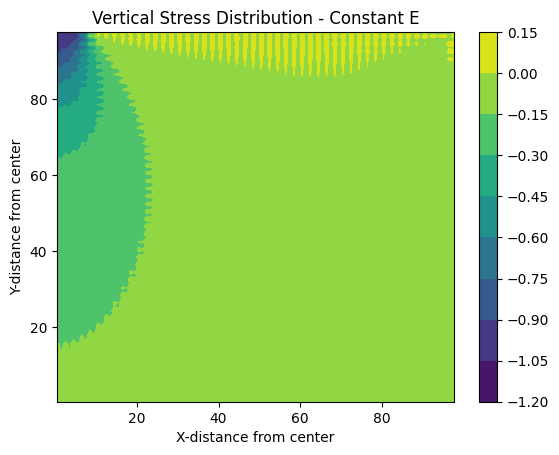

In [13]:
main(params)